In [2]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.special import gamma



imports work


In [2]:
hit_data_1093 = rf.get_ROOT_data_zip_RECO(1093)
# hit_data_1088 = rf.get_ROOT_data_zip_RECO(1088)

1093 RECONSTRUCTED finished


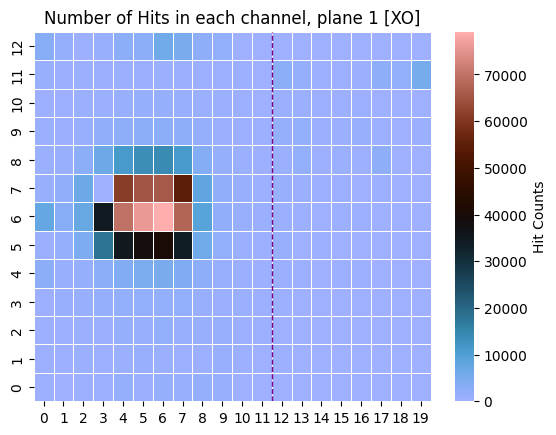

In [3]:
rf.hits_amount_colormap_single_plane(hit_data_1093,1)

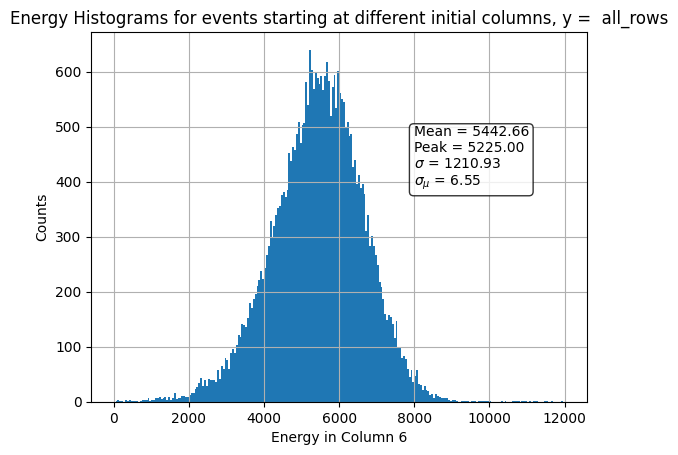

In [4]:
rf.shower_energy_histo_single_location(hit_data_1093, 6, bin_size=50)


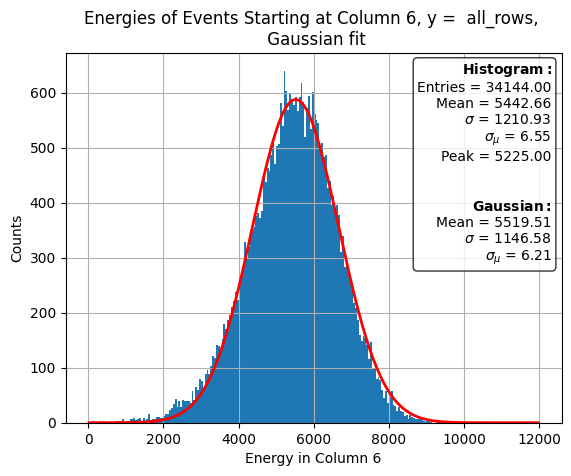

In [13]:
rf.Single_column_energy_histo_Gaussian_fit(hit_data_1093, 6, bin_size=50)

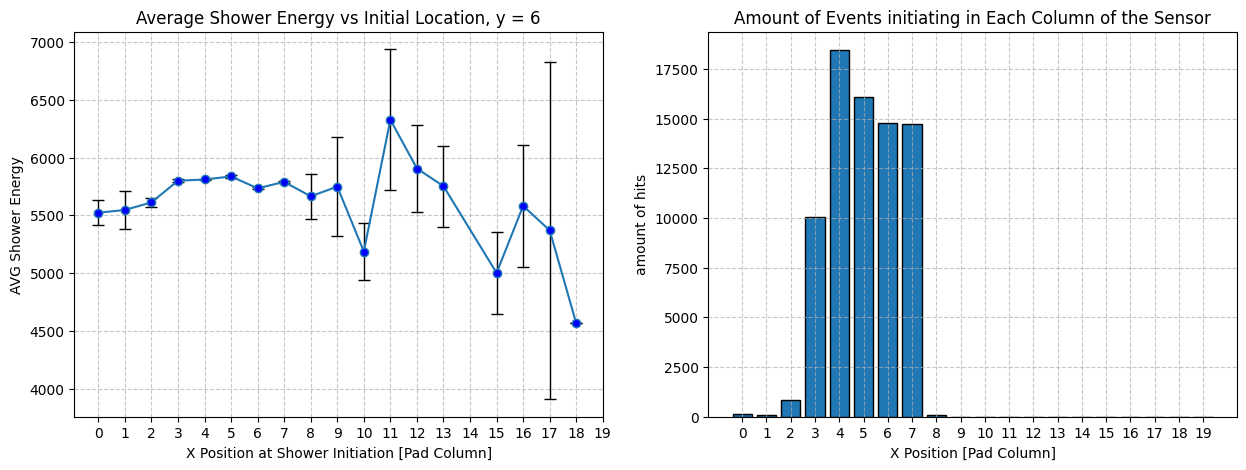

In [12]:
rf.event_shower_energy_vs_X_position(hit_data_1093, single_pad_only = "true", specific_Y=6)

In [3]:
hit_data_1340 = rf.get_ROOT_data_zip_RECO_11(1340)


1340 RECONSTRUCTED finished


In [ ]:
def channel_data_correction(hit_data, plane, dead_channel):

    # determine the surrounding pads
    neighbor_ch = [dead_channel+1, dead_channel-1, dead_channel+21, dead_channel+20, dead_channel+19, dead_channel-19, dead_channel-20,dead_channel-21]
    
    # get the data in the wanted plane
    hit_data_plane = hit_data[hit_data.plane == plane]

    # get the data to only the surrounding pads

    # calculate the average energy of surrounding pads to determine the energy in the dead one

    # attach the corrected data to the original



In [21]:
plane_5 = hit_data_1340[hit_data_1340.plane == 5]
plane_5.show()

[[{plane: 5, ch: 128, amp: 302}, {...}, {plane: 5, ch: 149, amp: 91}],
 [{plane: 5, ch: 126, amp: 268}, {...}, {plane: 5, ch: 147, amp: 154}],
 [{plane: 5, ch: 65, amp: 21}, {...}, ..., {...}, {plane: 5, ch: 224, amp: 16}],
 [{plane: 5, ch: 11, amp: 111}, {...}, ..., {plane: 5, ch: 169, amp: 15}],
 [{plane: 5, ch: 90, amp: 14}, {...}, ..., {...}, {plane: 5, ch: 151, amp: 15}],
 [{plane: 5, ch: 109, amp: 106}, {...}, ..., {plane: 5, ch: 131, amp: 132}],
 [{plane: 5, ch: 104, amp: 47}, {...}, ..., {...}, {plane: 5, ch: 180, amp: 6}],
 [{plane: 5, ch: 85, amp: 27}, {...}, ..., {...}, {plane: 5, ch: 167, amp: 58}],
 [{plane: 5, ch: 107, amp: 43}, {...}, ..., {plane: 5, ch: 211, amp: 42}],
 [{plane: 5, ch: 88, amp: 22}, {...}, ..., {...}, {plane: 5, ch: 185, amp: 74}],
 ...,
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]


In [41]:
plane_5_ch = plane_5[plane_5.ch == 127 & 126]
plane_5_ch

<Array [[], [{plane: 5, ...}], [], ..., [], []] type='501635 * var * {plane...'>

In [62]:
# Telescope
import pandas as pd
import gc

def process_single_file_awkward_vectorized(run_number):
    f = uproot.open(f"TB_FIRE/TB_reco/TB_FIRE_{run_number}_raw_reco.root")
    tele = uproot.open(f"TB_FIRE/TB_reco/run_{run_number}_telescope.root")

    arrs_events = f["Hits"].arrays(["TLU_number", "amplitude", "plane_ID", "ch_ID"], library="ak")
    tele_events = tele["TrackingInfo/Tracks"].arrays(["triggerid", "x_dut", "y_dut"], library="ak")

    arrs_events.TLU_number

    df_dut = pd.DataFrame({
        "TLU": ak.to_list(np.sort(arrs_events.TLU_number)),
        "amplitude": ak.to_list(arrs_events.amplitude),
        "plane_ID": ak.to_list(arrs_events.plane_ID),
        "ch_ID": ak.to_list(arrs_events.ch_ID)
    })

    nonempty_mask = (ak.num(tele_events["x_dut"]) == 1) & (ak.num(tele_events["y_dut"]) == 1)
    
    tele_trig_filtered = tele_events["triggerid"][nonempty_mask]
    tele_x_filtered    = tele_events["x_dut"][nonempty_mask]
    tele_y_filtered    = tele_events["y_dut"][nonempty_mask]

    flat_triggers = ak.to_list(ak.flatten(tele_trig_filtered, axis=None))
    flat_x       = ak.to_list(ak.flatten(tele_x_filtered, axis=None))
    flat_y       = ak.to_list(ak.flatten(tele_y_filtered, axis=None))

    df_tele = pd.DataFrame({
        "triggerid": np.sort(flat_triggers),
        "x_dut": flat_x,
        "y_dut": flat_y
    })
   
    print("DataFrames constructed.")

    df_tele = df_tele[df_tele["triggerid"].isin(df_dut["TLU"])]
    df_dut = df_dut[df_dut["TLU"].isin(df_tele["triggerid"])]
    
    # Group DUT hits by TLU
    grouped_dut = df_dut.groupby("TLU", sort=False).agg({
        "amplitude": lambda s: [item for sublist in s for item in (sublist if isinstance(sublist, list) else [sublist])],
        "plane_ID": lambda s: [item for sublist in s for item in (sublist if isinstance(sublist, list) else [sublist])],
        "ch_ID": lambda s: [item for sublist in s for item in (sublist if isinstance(sublist, list) else [sublist])]
    }).reset_index()

    # Group telescope hits by triggerid
    grouped_tele = df_tele.groupby("triggerid", sort=False).agg({
        "x_dut": lambda s: [item for sublist in s for item in (sublist if isinstance(sublist, list) else [sublist])],
        "y_dut": lambda s: [item for sublist in s for item in (sublist if isinstance(sublist, list) else [sublist])]
    }).reset_index().rename(columns={"triggerid": "TLU"})


    print("DataFrames grouped by TLU/triggerid")
    # Merge DUT and telescope on TLU
    merged = pd.merge(grouped_dut, grouped_tele, on="TLU", how="left")

    print("DataFrames merged")

    del flat_triggers, flat_x, flat_y, df_dut, df_tele, grouped_dut, grouped_tele
    gc.collect()

    print("collected garbage")

    events_awk = ak.zip({
        # "TLU": ak.Array(merged["TLU"].tolist()),
        "plane": ak.Array(merged["plane_ID"].tolist()),
        "ch": ak.Array(merged["ch_ID"].tolist()),
        "amp": ak.Array(merged["amplitude"].tolist()),
        "x": ak.flatten(ak.Array(merged["x_dut"].tolist()),axis=1),
        "y": ak.flatten(ak.Array(merged["y_dut"].tolist()),axis=1)
    })

    return events_awk


In [63]:
hit_data_scope = process_single_file_awkward_vectorized(1093)

DataFrames constructed.
DataFrames grouped by TLU/triggerid
DataFrames merged
collected garbage


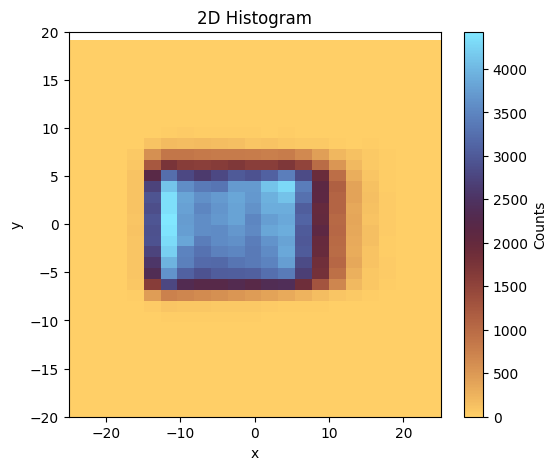

In [159]:
X = ak.mean(hit_data_scope.x, axis = 1)
Y = ak.mean(hit_data_scope.y, axis = 1)
amp = ak.sum(hit_data_scope.amp, axis = 1)


plt.figure(figsize=(6,5))
plt.hist2d(ak.to_numpy(X), ak.to_numpy(Y), bins=100,  cmap='managua')
plt.xlim(-25, 25) 
plt.ylim(-20, 20)
plt.colorbar(label="Counts")
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Histogram")
plt.show()

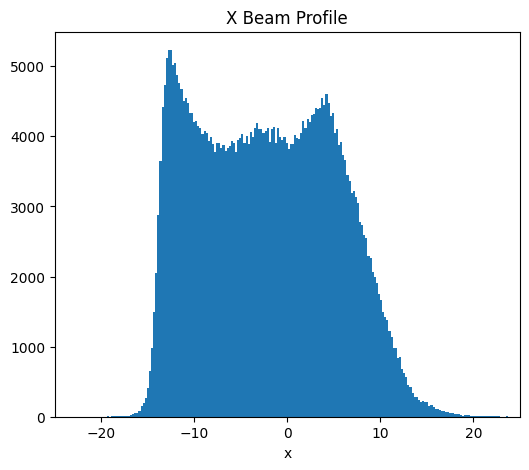

In [160]:
X = ak.mean(hit_data_scope.x, axis = 1)
Y = ak.mean(hit_data_scope.y, axis = 1)
amp = ak.sum(hit_data_scope.amp, axis = 1)


plt.figure(figsize=(6,5))
plt.hist(ak.to_numpy(X), bins=1000)
plt.xlim(-25, 25) 
plt.xlabel("x")
plt.title("X Beam Profile")
plt.show()

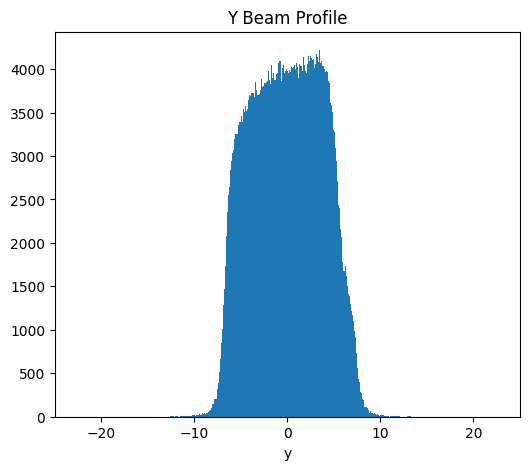

In [161]:
X = ak.mean(hit_data_scope.x, axis = 1)
Y = ak.mean(hit_data_scope.y, axis = 1)
amp = ak.sum(hit_data_scope.amp, axis = 1)


plt.figure(figsize=(6,5))
plt.hist(ak.to_numpy(Y), bins=1000)
plt.xlim(-25, 25) 
plt.xlabel("y")
plt.title("Y Beam Profile")
plt.show()

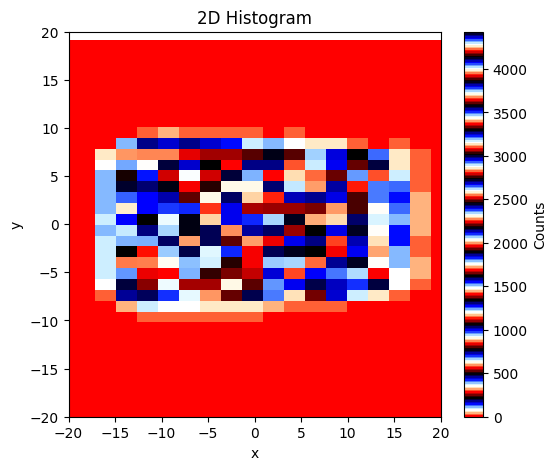

In [123]:
X = ak.mean(hit_data_scope.x, axis = 1)
Y = ak.mean(hit_data_scope.y, axis = 1)
amp = ak.sum(hit_data_scope.amp, axis = 1)


plt.figure(figsize=(6,5))
plt.hist2d(ak.to_numpy(X), ak.to_numpy(Y), bins=100,  cmap='flag')
plt.xlim(-20, 20) 
plt.ylim(-20, 20)
plt.colorbar(label="Counts")
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Histogram")
plt.show()

143.25632690452974 19.116527782051655
-82.65525185429762 -93.66073378027977


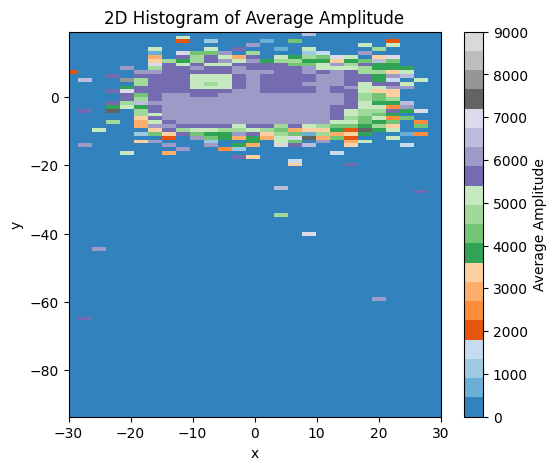

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

X = ak.to_numpy(ak.mean(hit_data_scope.x, axis=1))
print(max(X), max(Y))
print(min(X), min(Y))
Y = ak.to_numpy(ak.mean(hit_data_scope.y, axis=1))
amp = ak.to_numpy(ak.sum(hit_data_scope.amp, axis=1))

# Define bins
bins = 100

# Histogram of SUM of amplitudes
sum_amp, xedges, yedges = np.histogram2d(X, Y, bins=bins, weights=amp)

# Histogram of COUNTS
counts, _, _ = np.histogram2d(X, Y, bins=[xedges, yedges])

# Avoid division by zero
avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)

# Plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xedges, yedges, avg_amp.T, cmap="tab20c")  
plt.colorbar(label="Average Amplitude")
# plt.xlim(min(X), max(X))
plt.xlim(-30, 30)
plt.ylim(min(Y), max(Y))
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Histogram of Average Amplitude")
plt.show()


In [89]:

np.round(X)

<Array [9, -10, -13, -15, -9, ..., -5, -13, -12, -3, 5] type='440918 * float64'>

In [118]:
E = ak.sum(hit_data_scope.amp, axis = 1)
E

<Array [6145, 5271, 5409, 6194, ..., 4365, 3566, 2781] type='440918 * int64'>

In [130]:
data,amp,pos = rf.ak_groupby(X,E)

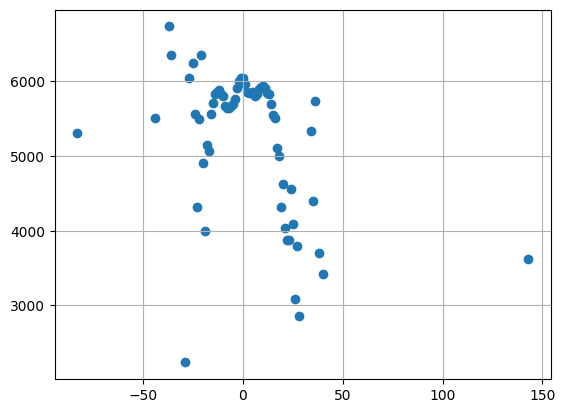

In [132]:
plt.scatter(pos,amp)
plt.grid()